In [2]:
# script to get linear fit for a given optimization file

In [45]:
import os
import glob
import numpy as np

import ase.atoms
import ase.io.gaussian

import xtb.ase.calculator

import matplotlib.pyplot as plt

In [54]:
def get_linear_fit(opt_files):
    m = None
    b = None
    xtb_energies = []
    m06_energies = []
    for opt_file in opt_files:
        with open(opt_file, 'r') as f:
            frames = ase.io.gaussian.read_gaussian_out(f, slice(None, None))


        for j in range(len(frames)):
            if not frames[j].calc.results or 'forces' not in frames[j].calc.results.keys():
                continue

            m06_energies.append(frames[j].calc.results['energy'])
            atoms = ase.Atoms(frames[j].numbers, frames[j].positions)
            atoms.calc = xtb.ase.calculator.XTB()
            xtb_energies.append(atoms.get_potential_energy())
        if len(xtb_energies) < 2:
            print('Not enough optimization points for a linear fit!')
            return m, b

        # fit a line
        m, b = np.polyfit(xtb_energies, m06_energies, 1)
    return m, b

In [47]:
# opt_file = '/work/westgroup/harris.se/autoscience/reaction_calculator/dft/thermo/species_0004/conformers/conformer_0000.log'
opt_files = [
    '/work/westgroup/harris.se/autoscience/reaction_calculator/dft/kinetics/reaction_000213/overall/fwd_ts_0000.log'
    '/work/westgroup/harris.se/autoscience/reaction_calculator/dft/kinetics/reaction_000213/overall/fwd_ts_0000.log'
]
opt_files = glob.glob('/work/westgroup/harris.se/autoscience/reaction_calculator/dft/kinetics/reaction_000213/*/fwd_ts_*.log')


xtb_energies = []
m06_energies = []
for opt_file in opt_files:
    with open(opt_file, 'r') as f:
        frames = ase.io.gaussian.read_gaussian_out(f, slice(None, None))
    
    for j in range(len(frames)):
        if not frames[j].calc.results or 'forces' not in frames[j].calc.results.keys():
            continue

        m06_energies.append(frames[j].calc.results['energy'])
        atoms = ase.Atoms(frames[j].numbers, frames[j].positions)
        atoms.calc = xtb.ase.calculator.XTB()
        xtb_energies.append(atoms.get_potential_energy())
   

In [48]:
len(xtb_energies)

89

In [49]:
len(m06_energies)

89

In [50]:

np.random.seed(400)


train_split = 0.6

# Shuffle the data
combined = np.vstack((m06_energies, xtb_energies)).transpose()
np.random.shuffle(combined)
ref_energies_shuffled = combined[:, 0]
my_calc_energies_shuffled = combined[:, 1]


# pick out the train and test sets
train_test_divide = int(train_split * len(my_calc_energies_shuffled))
train_ref_energy = ref_energies_shuffled[:train_test_divide]
train_calc_energy = my_calc_energies_shuffled[:train_test_divide]
test_ref_energy = ref_energies_shuffled[train_test_divide:]
test_calc_energy = my_calc_energies_shuffled[train_test_divide:]


In [51]:
# fit a line
m, b = np.polyfit(train_calc_energy, train_ref_energy, 1)

Train MSE: 0.04802798202830295
Train mean percent error: 0.00%
R^2: 0.81630


Text(0, 0.5, 'M06-2X Energies')

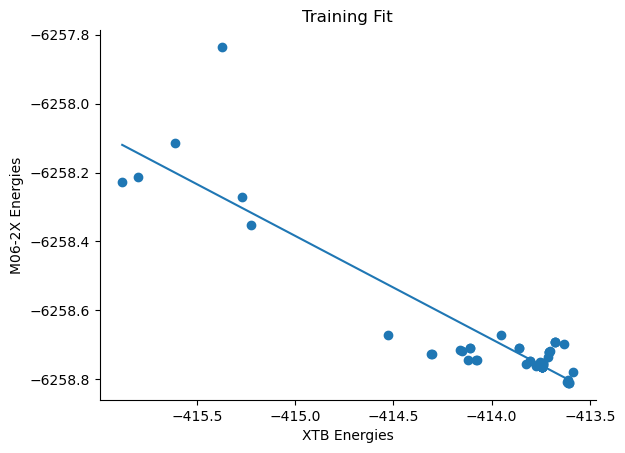

In [52]:
# plot results:
plt.scatter(train_calc_energy, train_ref_energy)

fit_energies = m * train_calc_energy + b

train_mae = np.average(np.abs(fit_energies - train_ref_energy))
train_mean_percent_error = np.average(np.abs(np.divide(fit_energies - train_ref_energy, train_ref_energy))) * 100.0

print(f'Train MSE: {train_mae}')
print(f'Train mean percent error: {train_mean_percent_error:.2f}%')

corr_matrix = np.corrcoef(train_ref_energy, fit_energies)
corr = corr_matrix[0, 1]
R_sq = corr ** 2
print(f'R^2: {R_sq:.5f}')

x = np.linspace(np.min(train_calc_energy), np.max(train_calc_energy), 101)
est_m06_energies = m * x + b
plt.plot(x, est_m06_energies)
plt.title('Training Fit')
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.get_major_formatter().set_useOffset(False)
plt.xlabel('XTB Energies')
plt.ylabel('M06-2X Energies')

Test MSE: 0.06572982424088675
Test mean percent error: 0.00%
R^2: 0.42814


Text(0, 0.5, 'M06-2X Energies')

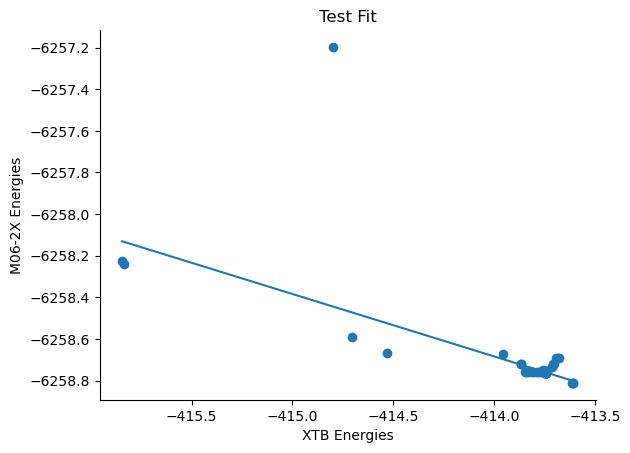

In [53]:
fit_energies = m * test_calc_energy + b
test_mae = np.average(np.abs(fit_energies - test_ref_energy))
test_mean_percent_error = np.average(np.abs(np.divide(fit_energies - test_ref_energy, test_ref_energy))) * 100.0

print(f'Test MSE: {test_mae}')
print(f'Test mean percent error: {test_mean_percent_error:.2f}%')
corr_matrix = np.corrcoef(test_ref_energy, fit_energies)
corr = corr_matrix[0, 1]
R_sq = corr ** 2
print(f'R^2: {R_sq:.5f}')

plt.scatter(test_calc_energy, test_ref_energy)

x = np.linspace(np.min(test_calc_energy), np.max(test_calc_energy), 101)
est_m06_energies = m * x + b
plt.plot(x, est_m06_energies)
plt.title('Test Fit')
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.get_major_formatter().set_useOffset(False)
plt.xlabel('XTB Energies')
plt.ylabel('M06-2X Energies')

In [27]:
print(f'm = {m}')
print(f'b = {b}')

m = -0.05061874294523105
b = -6279.685195572137
